In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/AMS.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,2.70,2.80,2.70,2.8,2.8,5600
1,1/3/2013,2.75,2.81,2.74,2.8,2.8,4500
2,1/4/2013,2.80,2.80,2.80,2.8,2.8,0
3,1/7/2013,2.75,2.75,2.70,2.7,2.7,400
4,1/8/2013,2.70,2.70,2.60,2.6,2.6,500


In [3]:
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\Magda\anaconda3\lib\site-packages\ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


epoch: 10, total rewards: -13.049999.3, cost: -35307.214844, total money: 9839.530000
epoch: 20, total rewards: -8.179999.3, cost: -35595.117188, total money: 9991.820001
epoch: 30, total rewards: -33.420000.3, cost: -35540.535156, total money: 9961.580000
epoch: 40, total rewards: -41.620001.3, cost: -35450.390625, total money: 9862.859998
epoch: 50, total rewards: -34.390000.3, cost: -35608.984375, total money: 9916.829999
epoch: 60, total rewards: -15.509998.3, cost: -35708.320312, total money: 9969.700002
epoch: 70, total rewards: -11.619998.3, cost: -35691.085938, total money: 9921.050002
epoch: 80, total rewards: -12.359999.3, cost: -35715.984375, total money: 9930.980001
epoch: 90, total rewards: -10.059999.3, cost: -35749.160156, total money: 9933.040001
epoch: 100, total rewards: -3.799998.3, cost: -35787.152344, total money: 9936.970001
epoch: 110, total rewards: 2.840002.3, cost: -35806.929688, total money: 9948.780002
epoch: 120, total rewards: 16.270004.3, cost: -35832.984

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 6: buy 1 unit at price 2.570000, total balance 9997.430000
day 7, sell 1 unit at price 2.570000, investment 0.000000 %, total balance 10000.000000,
day 12: buy 1 unit at price 2.320000, total balance 9997.680000
day 14, sell 1 unit at price 2.190000, investment -5.603443 %, total balance 9999.870000,
day 18: buy 1 unit at price 2.210000, total balance 9997.660000
day 20: buy 1 unit at price 2.250000, total balance 9995.410000
day 21, sell 1 unit at price 2.230000, investment 0.904977 %, total balance 9997.640000,
day 23: buy 1 unit at price 2.250000, total balance 9995.390000
day 24, sell 1 unit at price 2.210000, investment -1.777776 %, total balance 9997.600000,
day 25, sell 1 unit at price 2.180000, investment -3.111108 %, total balance 9999.780000,
day 27: buy 1 unit at price 2.180000, total balance 9997.600000
day 28, sell 1 unit at price 2.060000, investment -5.504593 %, total balance 9999.660000,
day 33: buy 1 unit at price 2.260000, total balance 9997.400000
day 34, sell 1 

day 289, sell 1 unit at price 3.160000, investment 4.983392 %, total balance 9949.150000,
day 290, sell 1 unit at price 3.110000, investment 18.702291 %, total balance 9952.260000,
day 291, sell 1 unit at price 3.050000, investment 9.318996 %, total balance 9955.310000,
day 293, sell 1 unit at price 3.040000, investment 16.030538 %, total balance 9958.350000,
day 294: buy 1 unit at price 3.070000, total balance 9955.280000
day 295, sell 1 unit at price 3.120000, investment 9.473684 %, total balance 9958.400000,
day 296, sell 1 unit at price 3.270000, investment 23.396221 %, total balance 9961.670000,
day 297, sell 1 unit at price 3.290000, investment 9.666665 %, total balance 9964.960000,
day 301, sell 1 unit at price 3.000000, investment 2.040814 %, total balance 9967.960000,
day 302, sell 1 unit at price 3.000000, investment 1.694914 %, total balance 9970.960000,
day 303: buy 1 unit at price 3.200000, total balance 9967.760000
day 304, sell 1 unit at price 3.260000, investment 9.0301

day 457: buy 1 unit at price 2.200000, total balance 9965.250000
day 458: buy 1 unit at price 2.180000, total balance 9963.070000
day 459: buy 1 unit at price 2.190000, total balance 9960.880000
day 460, sell 1 unit at price 2.200000, investment -9.465021 %, total balance 9963.080000,
day 462, sell 1 unit at price 2.190000, investment -8.750001 %, total balance 9965.270000,
day 463: buy 1 unit at price 2.620000, total balance 9962.650000
day 465, sell 1 unit at price 2.670000, investment 16.086962 %, total balance 9965.320000,
day 466: buy 1 unit at price 2.750000, total balance 9962.570000
day 467: buy 1 unit at price 2.660000, total balance 9959.910000
day 468, sell 1 unit at price 2.440000, investment 10.407240 %, total balance 9962.350000,
day 469, sell 1 unit at price 2.440000, investment 12.442395 %, total balance 9964.790000,
day 470, sell 1 unit at price 2.510000, investment 20.095698 %, total balance 9967.300000,
day 471, sell 1 unit at price 2.720000, investment 26.511624 %, 

day 608: buy 1 unit at price 2.400000, total balance 9967.870000
day 609, sell 1 unit at price 2.400000, investment -11.111109 %, total balance 9970.270001,
day 610, sell 1 unit at price 2.360000, investment -13.868617 %, total balance 9972.630000,
day 611: buy 1 unit at price 2.360000, total balance 9970.270001
day 612, sell 1 unit at price 2.370000, investment -13.503654 %, total balance 9972.640000,
day 613, sell 1 unit at price 2.590000, investment -6.834534 %, total balance 9975.230000,
day 615, sell 1 unit at price 2.580000, investment -3.370792 %, total balance 9977.810000,
day 616, sell 1 unit at price 2.620000, investment 3.149603 %, total balance 9980.430000,
day 617: buy 1 unit at price 2.700000, total balance 9977.730000
day 618, sell 1 unit at price 2.690000, investment 4.263571 %, total balance 9980.420000,
day 621: buy 1 unit at price 2.650000, total balance 9977.770000
day 622: buy 1 unit at price 2.680000, total balance 9975.090000
day 624, sell 1 unit at price 2.55000

day 757, sell 1 unit at price 1.750000, investment 6.060608 %, total balance 9968.960000,
day 758: buy 1 unit at price 1.740000, total balance 9967.220000
day 760, sell 1 unit at price 1.620000, investment -2.994009 %, total balance 9968.840000,
day 761, sell 1 unit at price 1.600000, investment -8.045976 %, total balance 9970.440000,
day 762: buy 1 unit at price 1.650000, total balance 9968.790000
day 763: buy 1 unit at price 1.650000, total balance 9967.140000
day 764, sell 1 unit at price 1.920000, investment -1.538466 %, total balance 9969.060000,
day 765: buy 1 unit at price 1.920000, total balance 9967.140000
day 768, sell 1 unit at price 1.910000, investment -0.520833 %, total balance 9969.050000,
day 769: buy 1 unit at price 1.860000, total balance 9967.190000
day 770, sell 1 unit at price 1.980000, investment 4.210529 %, total balance 9969.170000,
day 772: buy 1 unit at price 1.570000, total balance 9967.600000
day 773: buy 1 unit at price 1.570000, total balance 9966.030000
d

day 1049, sell 1 unit at price 4.100000, investment -1.204824 %, total balance 9988.500000,
day 1050: buy 1 unit at price 4.050000, total balance 9984.449999
day 1052: buy 1 unit at price 4.050000, total balance 9980.399999
day 1053, sell 1 unit at price 3.950000, investment -10.227274 %, total balance 9984.349999,
day 1054, sell 1 unit at price 3.950000, investment -7.058822 %, total balance 9988.299999,
day 1055: buy 1 unit at price 3.850000, total balance 9984.449999
day 1056, sell 1 unit at price 3.850000, investment -3.750002 %, total balance 9988.299999,
day 1058, sell 1 unit at price 3.850000, investment -4.938278 %, total balance 9992.149999,
day 1060: buy 1 unit at price 4.050000, total balance 9988.099999
day 1061: buy 1 unit at price 3.950000, total balance 9984.149999
day 1062, sell 1 unit at price 4.000000, investment 0.000000 %, total balance 9988.149999,
day 1063, sell 1 unit at price 4.530000, investment 11.851852 %, total balance 9992.679999,
day 1064, sell 1 unit at p

day 1205, sell 1 unit at price 2.950000, investment 3.146859 %, total balance 9942.890000,
day 1207: buy 1 unit at price 3.050000, total balance 9939.840000
day 1211: buy 1 unit at price 3.150000, total balance 9936.690000
day 1214, sell 1 unit at price 3.100000, investment 10.714284 %, total balance 9939.790000,
day 1216: buy 1 unit at price 3.100000, total balance 9936.690000
day 1217, sell 1 unit at price 3.100000, investment 9.154930 %, total balance 9939.790000,
day 1218: buy 1 unit at price 3.050000, total balance 9936.740000
day 1219: buy 1 unit at price 3.050000, total balance 9933.690000
day 1220: buy 1 unit at price 3.070000, total balance 9930.620000
day 1221: buy 1 unit at price 3.050000, total balance 9927.570000
day 1223: buy 1 unit at price 3.000000, total balance 9924.570000
day 1224: buy 1 unit at price 3.050000, total balance 9921.520000
day 1226, sell 1 unit at price 2.800000, investment 0.000000 %, total balance 9924.320000,
day 1227: buy 1 unit at price 2.750000, t

day 1366: buy 1 unit at price 2.700000, total balance 9967.200000
day 1367: buy 1 unit at price 2.700000, total balance 9964.500000
day 1369: buy 1 unit at price 2.650000, total balance 9961.850000
day 1370, sell 1 unit at price 2.750000, investment 10.000000 %, total balance 9964.600000,
day 1371: buy 1 unit at price 2.650000, total balance 9961.950000
day 1372, sell 1 unit at price 2.680000, investment 0.000000 %, total balance 9964.630000,
day 1374: buy 1 unit at price 2.750000, total balance 9961.880000
day 1378, sell 1 unit at price 2.650000, investment -8.304498 %, total balance 9964.530000,
day 1379: buy 1 unit at price 2.650000, total balance 9961.880000
day 1380, sell 1 unit at price 2.650000, investment -1.851850 %, total balance 9964.530000,
day 1381, sell 1 unit at price 2.550000, investment -7.272729 %, total balance 9967.080000,
day 1382: buy 1 unit at price 2.650000, total balance 9964.430000
day 1383, sell 1 unit at price 2.750000, investment -0.362318 %, total balance 

day 1535, sell 1 unit at price 2.510000, investment -0.396825 %, total balance 9944.110000,
day 1538, sell 1 unit at price 2.510000, investment -0.790513 %, total balance 9946.620000,
day 1539, sell 1 unit at price 2.590000, investment 3.599997 %, total balance 9949.210000,
day 1540, sell 1 unit at price 2.530000, investment 7.203393 %, total balance 9951.740000,
day 1541, sell 1 unit at price 2.560000, investment 8.016880 %, total balance 9954.300000,
day 1542, sell 1 unit at price 2.550000, investment 4.508192 %, total balance 9956.850000,
day 1543: buy 1 unit at price 2.560000, total balance 9954.290000
day 1546, sell 1 unit at price 2.880000, investment 15.200005 %, total balance 9957.170000,
day 1547, sell 1 unit at price 2.950000, investment 17.529883 %, total balance 9960.120000,
day 1548: buy 1 unit at price 2.910000, total balance 9957.210000
day 1549: buy 1 unit at price 2.950000, total balance 9954.260000
day 1550: buy 1 unit at price 2.820000, total balance 9951.440000
day 

day 1707: buy 1 unit at price 2.360000, total balance 9939.760001
day 1708: buy 1 unit at price 2.430000, total balance 9937.330001
day 1710: buy 1 unit at price 2.440000, total balance 9934.890001
day 1712: buy 1 unit at price 2.450000, total balance 9932.440001
day 1713: buy 1 unit at price 2.450000, total balance 9929.990000
day 1714, sell 1 unit at price 2.450000, investment -14.634141 %, total balance 9932.440001,
day 1715, sell 1 unit at price 2.420000, investment -7.633581 %, total balance 9934.860001,
day 1716, sell 1 unit at price 2.420000, investment -8.333334 %, total balance 9937.280001,
day 1719: buy 1 unit at price 2.400000, total balance 9934.880001
day 1720: buy 1 unit at price 2.380000, total balance 9932.500000
day 1722: buy 1 unit at price 2.390000, total balance 9930.110000
day 1723: buy 1 unit at price 2.420000, total balance 9927.690000
day 1724: buy 1 unit at price 2.530000, total balance 9925.160000
day 1725: buy 1 unit at price 2.500000, total balance 9922.6600

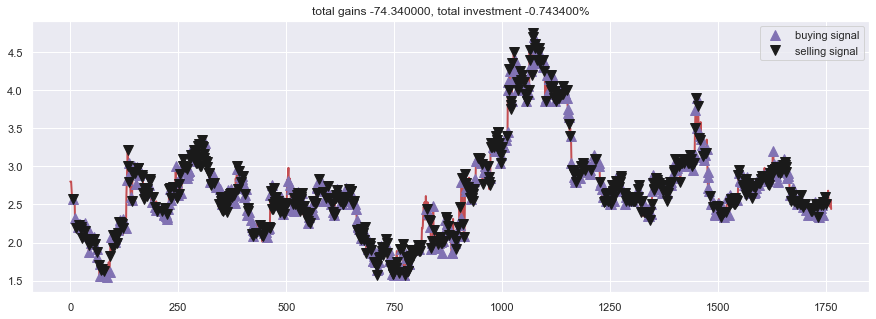

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()